In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers;
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


In [19]:
import keras
from keras.utils import CustomObjectScope

from keras.initializers import glorot_uniform
import tensorflowjs as tfjs

In [2]:
# Load data from a CSV containing samples from California from the years 1991 through 1995
column_names1 = ["layer_key", "pH_h2o_8C1f_Sjj_(NA)_123_CMS_0_0", "OC_6A1c_Sjj_% wt_119_CMS_0_0"]
oc = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 91-95 Andic/Andic_Soil_Properties_Tier_2.csv", usecols = column_names1, skipinitialspace=True, na_values = ["--", "tr"])
oc = oc.dropna()

column_names2 = ["layer_key", "ClyT_p_3A1_Sjj_% wt_0_CMS_0_0"]
clay = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 91-95 Andic/Andic_Soil_Properties_Tier_1.csv", usecols = column_names2, skipinitialspace=True, na_values = ["--", "tr"])
clay = clay.dropna()

column_names3 = ["layer_key", "Ca_nh4_6N2e_Sjj_cmol(+)/kg_114_CMS_0_0", 
                 "Mg_nh4_6O2d_Sjj_cmol(+)/kg_114_CMS_0_0", "Na_nh4_6P2b_Sjj_cmol(+)/kg_114_CMS_0_0",
                 "K_nh4_6Q2b_Sjj_cmol(+)/kg_114_CMS_0_0", "CECnh4_5A8b_Sjj_cmol(+)/kg_121_CMS_0_0",
                 "CECsum_d-0_S"]
minerals = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 91-95 Geochemistry 2/Geochemistry_Tier_2.csv", usecols = column_names3, skipinitialspace=True, na_values = ["--", "tr"])
minerals = minerals.dropna()

merged = pd.merge(oc, clay)
merged = pd.merge(merged, minerals)
len(merged)

513

In [3]:
# Load data from a CSV containing samples from California from the years 1988 through 1990
column_names1 = ["layer_key", "pH_h2o_8C1f_Sjj_(NA)_123_CMS_0_0", "OC_6A1c_Sjj_% wt_119_CMS_0_0"]
oc = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 88-90 Geochemistry 2 Andic/Andic_Soil_Properties_Tier_2.csv", usecols = column_names1, skipinitialspace=True, na_values = ["--", "tr"])
oc = oc.dropna()

column_names2 = ["layer_key", "ClyT_p_3A1_Sjj_% wt_0_CMS_0_0"]
clay = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 88-90 Geochemistry 2 Andic/Andic_Soil_Properties_Tier_1.csv", usecols = column_names2, skipinitialspace=True, na_values = ["--", "tr"])
clay = clay.dropna()

column_names3 = ["layer_key", "Ca_nh4_6N2e_Sjj_cmol(+)/kg_114_CMS_0_0", 
                 "Mg_nh4_6O2d_Sjj_cmol(+)/kg_114_CMS_0_0", "Na_nh4_6P2b_Sjj_cmol(+)/kg_114_CMS_0_0",
                 "K_nh4_6Q2b_Sjj_cmol(+)/kg_114_CMS_0_0", "CECnh4_5A8b_Sjj_cmol(+)/kg_121_CMS_0_0",
                 "CECsum_d-0_S"]
minerals = pd.read_csv("C:/Users/[user]/Desktop/SOM Project/California 88-90 Geochemistry 2 Andic/Geochemistry_Tier_2.csv", usecols = column_names3, skipinitialspace=True, na_values = ["--", "tr"])
minerals = minerals.dropna()

merged2 = pd.merge(oc, clay)
merged2 = pd.merge(merged2, minerals)
len(merged2)

175

In [25]:
merged = merged.append(merged2)
print("Total number of samples:")
len(merged)

Total number of samples:


863

In [5]:
merged.pop('layer_key');

In [6]:
# Create training and testing data set, create labels
train_dataset = merged.sample(frac=0.8, random_state=0)
test_dataset = merged.drop(train_dataset.index)

train_stats = train_dataset.describe()
test_stats = test_dataset.describe()

train_stats = train_stats.transpose()
test_stats = test_stats.transpose()

train_labels = train_dataset.pop('OC_6A1c_Sjj_% wt_119_CMS_0_0')
test_labels = test_dataset.pop('OC_6A1c_Sjj_% wt_119_CMS_0_0')

This model uses standard score normalization for the inputs, leaves the outputs un-normalized.
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5fa4ed805c338486b0c852cca4b8e38ee9300870 "title")


In [8]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.pop('OC_6A1c_Sjj_% wt_119_CMS_0_0');
normed_test_data.pop('OC_6A1c_Sjj_% wt_119_CMS_0_0');

In [11]:
def build_model():
  # Set the dimensions
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
    
  # Uses AdaMax optimizer
  optimizer = keras.optimizers.Adamax(0.002, beta_1=0.99, beta_2=0.999)

  # Uses mean squared error as the loss metric
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape', keras.metrics.CosineSimilarity(axis=1)])
    


  return model



In [13]:
model = build_model();

# Run for maximum of 1000 epochs
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop]);


In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

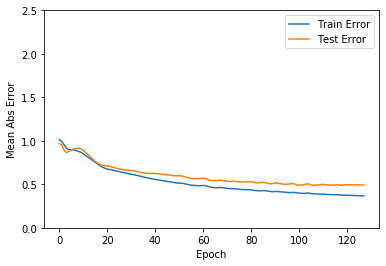

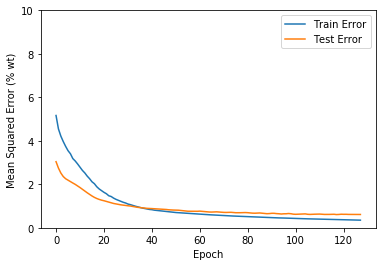

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Test Error')
  plt.ylim([0,2.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error (% wt)')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Test Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)


Graphs of the loss of the neural network as it was being trained

In [21]:
test_predictions = model.predict(normed_test_data)

In [23]:
loss, mae, mse, mape, cosine = model.evaluate(normed_test_data, test_labels, verbose=3);

print("Testing set Mean Absolute Error: {:5.2f} OC % weight".format(mae))

Testing set Mean Absolute Error:  0.53 OC % weight


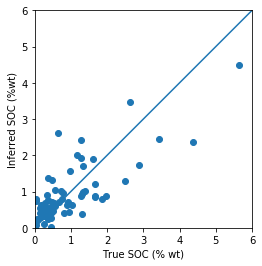

In [26]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True SOC (% wt)')
plt.ylabel('Inferred SOC (%wt)')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [29]:
# Save the model as a file that can later be used by the desktop application
model.save('my_model.h5')